In [1]:
!pip install catboost

In [2]:
!pip install -q tensorflow==2.3

In [3]:
#аугментации изображений
!pip install albumentations -q

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.18.1
Tensorflow   : 2.3.0


In [6]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [7]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [8]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [9]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [11]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [12]:
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [13]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

Посмотрим, как выглядят распределения числовых признаков:

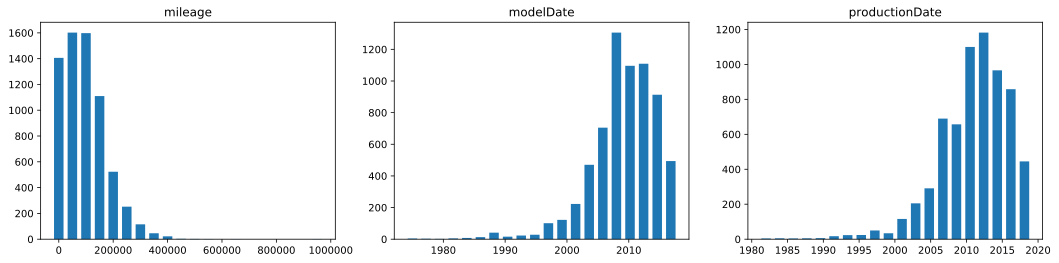

In [14]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

Итого:

    CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

# PreProc Tabular Data

In [15]:
#убираем признаки: 'name','Владельцы','ПТС'
categorical_features = ['bodyType', 'brand', 'color', 'fuelType', 'model_info',
  'numberOfDoors', 'vehicleTransmission', 'Привод', 'Руль']

#используем все числовые признаки
numerical_features = ['mileage', 'modelDate', 'productionDate','Владение','enginePower','engineDisplacement']

In [16]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [17]:
data.isna().sum()

bodyType                   0
brand                      0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_info                 0
name                       0
numberOfDoors              0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  1
Владение                5418
ПТС                        0
Привод                     0
Руль                       0
sample                     0
price                      0
dtype: int64

In [18]:
data.sample(3)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price
7399,внедорожник 5 дв.,BMW,коричневый,"Авто в одних руках,все обслуживание по реглам...",2.0 LTR,245 N12,бензин,107000,2014,X3,...,1091374938,ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,1 владелец,4 года и 9 месяцев,Оригинал,полный,Левый,1,1590000.0
4273,внедорожник 5 дв.,BMW,чёрный,"Год выпуска 2016, приобрел новую без пробега в...",2.0 LTR,245 N12,гибрид,45000,2013,X5,...,1099098578,ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,1 владелец,2 года и 6 месяцев,Оригинал,полный,Левый,1,3100000.0
3362,седан,MERCEDES,чёрный,В идеальном состоянии. Обслуживание в Панавто ...,5.5 LTR,585 N12,бензин,55000,2013,S_KLASSE_AMG,...,1094635516,SEDAN AUTOMATIC 5.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый,1,3750000.0


In [19]:
data.columns

Index(['bodyType', 'brand', 'color', 'description', 'engineDisplacement',
       'enginePower', 'fuelType', 'mileage', 'modelDate', 'model_info', 'name',
       'numberOfDoors', 'productionDate', 'sell_id', 'vehicleConfiguration',
       'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль',
       'sample', 'price'],
      dtype='object')

In [20]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['description','sell_id', 'name','Владельцы','ПТС'], axis = 1, inplace=True)
    
     # ################### Feature Engineering ####################################################
    #Владение
    def num_of_months(row):
        if pd.notnull(row):
            list_ownership = row.split()
            if len(list_ownership) == 2:
                if list_ownership[1] in ['год', 'года', 'лет']:
                    return int(list_ownership[0])*12
                return int(list_ownership[0])
            return int(list_ownership[0])*12 + int(list_ownership[3])
    df_output['Владение'] = df_output['Владение'].apply(num_of_months)
    
    # enginePower, оставим только цифру в enginePower
    df_output['enginePower'] = df_output['enginePower'].apply(lambda x: int(x.split()[0]))
    
     # engineDisplacement, оставим только цифру в engineDisplacement
    df_output['engineDisplacement'][df_output['engineDisplacement'] == 'undefined LTR'] = 'NaN'    
    df_output['engineDisplacement'] = df_output['engineDisplacement'].apply(lambda x: float(x.split()[0]))
    
    
    # ################### Numerical Features ############################################################## 
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)
        if column == 'modelDate':
            df_output['modelDate'] = np.log(2020 - data['modelDate'])
        else:
            df_output[column]=df_output[column].apply(lambda x: np.log(x))
    
    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    
    # ################### Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    df_output.drop(['vehicleConfiguration'], axis = 1, inplace=True)
    
    return df_output

In [21]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

C:\Users\Admin\anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,engineDisplacement,enginePower,mileage,modelDate,productionDate,Владение,sample,price,bodyType_0,bodyType_1,...,numberOfDoors_3,vehicleTransmission_0,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1
3640,0.467888,0.439126,0.891384,0.638495,0.686257,0.840323,1,630000.0,0,0,...,1,0,0,0,1,0,0,1,1,0
6421,0.467888,0.310328,0.866257,0.616137,0.791046,0.619468,1,680000.0,0,1,...,1,1,0,0,0,1,0,0,1,0
7645,0.420931,0.339223,0.829621,0.659062,0.712474,0.619468,1,599000.0,0,0,...,0,0,1,0,0,0,1,0,1,0
7222,0.467888,0.529985,0.757345,0.413544,0.895627,0.619468,1,2150000.0,0,1,...,1,1,0,0,0,0,0,1,1,0
4604,0.648598,0.553132,0.852324,0.616137,0.791046,0.619468,1,1290000.0,0,0,...,0,1,0,0,0,0,0,1,1,0
5140,0.275896,0.310328,0.673618,0.178104,0.973926,0.619468,1,1898000.0,0,0,...,1,0,0,0,1,0,1,0,1,0
728,0.420931,0.339223,0.866900,0.659062,0.764868,0.354121,0,0.0,0,0,...,0,0,1,0,0,0,1,0,1,0
7029,0.567340,0.477709,0.830379,0.742679,0.633785,0.449422,1,675000.0,0,0,...,0,1,0,0,0,1,0,0,1,0
1997,0.648598,0.629523,0.893054,0.659062,0.712474,0.619468,1,970000.0,0,1,...,1,1,0,0,0,0,0,1,1,0
3433,0.467888,0.463097,0.867353,0.564575,0.791046,0.619468,1,890000.0,0,0,...,1,0,0,0,1,0,0,1,1,0


In [23]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 183 entries, engineDisplacement to Руль_1
dtypes: float64(7), int64(1), uint8(175)
memory usage: 1.9 MB


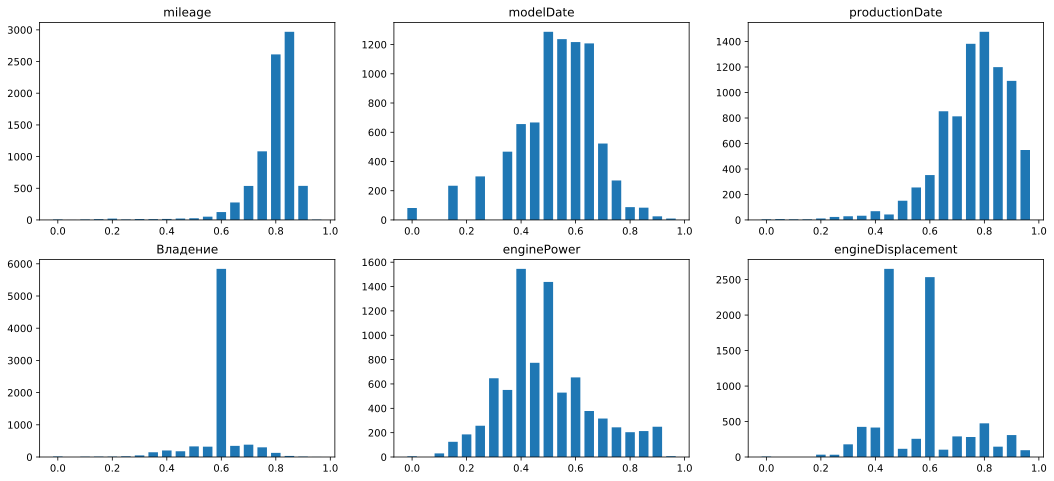

In [30]:
visualize_distributions({
    'mileage': df_preproc['mileage'].dropna(),
    'modelDate': df_preproc['modelDate'].dropna(),
    'productionDate': df_preproc['productionDate'].dropna(),
    'Владение': df_preproc['Владение'].dropna(),
    'enginePower': df_preproc['enginePower'].dropna(),
    'engineDisplacement': df_preproc['engineDisplacement'].dropna()
})

## Split data

In [31]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [32]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 182 entries, engineDisplacement to Руль_1
dtypes: float64(7), uint8(175)
memory usage: 390.0 KB


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

# Model 2: CatBoostRegressor

In [34]:
# model = CatBoostRegressor(iterations = 5000,
#                           #depth=10,
#                           #learning_rate = 0.5,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['RMSE', 'MAE'],
#                           od_wait=500,
#                           #task_type='GPU',
#                          )
# model.fit(X_train, y_train,
#          eval_set=(X_test, y_test),
#          verbose_eval=100,
#          use_best_model=True,
#          #plot=True
#          )

Learning rate set to 0.023474
0:	learn: 0.9865342	test: 1.0105737	best: 1.0105737 (0)	total: 52.5ms	remaining: 4m 22s
100:	learn: 0.2996301	test: 0.3001372	best: 0.3001275 (99)	total: 294ms	remaining: 14.3s
200:	learn: 0.2351750	test: 0.2335744	best: 0.2335744 (200)	total: 494ms	remaining: 11.8s
300:	learn: 0.1991956	test: 0.1981523	best: 0.1981523 (300)	total: 696ms	remaining: 10.9s
400:	learn: 0.1825548	test: 0.1830305	best: 0.1830305 (400)	total: 903ms	remaining: 10.4s
500:	learn: 0.1760103	test: 0.1778768	best: 0.1778768 (500)	total: 1.13s	remaining: 10.1s
600:	learn: 0.1672064	test: 0.1700182	best: 0.1700182 (600)	total: 1.35s	remaining: 9.91s
700:	learn: 0.1590247	test: 0.1627016	best: 0.1625978 (699)	total: 1.58s	remaining: 9.7s
800:	learn: 0.1533892	test: 0.1581479	best: 0.1581479 (800)	total: 1.8s	remaining: 9.47s
900:	learn: 0.1491292	test: 0.1557754	best: 0.1556546 (891)	total: 2.01s	remaining: 9.16s
1000:	learn: 0.1448671	test: 0.1522253	best: 0.1522253 (1000)	total: 2.23s	

In [35]:
# test_predict_catboost = model.predict(X_test)
# print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 12.63%


### Submission

In [36]:
# sub_predict_catboost = model.predict(X_sub)
# sample_submission['price'] = sub_predict_catboost
# sample_submission['price'] = sample_submission['price'].apply(lambda x: round(x//1000)*1000)
# sample_submission.to_csv('catboost_submission-v2.csv', index=False)

In [37]:
# sample_submission.head()

,sell_id,price
0,1099427284,489000
1,1096405886,2253000
2,1100195294,658000
3,1099827282,430000
4,1100076198,2684000


# Model 3: Tabular NN

Построим обычную сеть:

In [38]:
X_train.head(5)

,engineDisplacement,enginePower,mileage,modelDate,productionDate,Владение,bodyType_0,bodyType_1,bodyType_2,bodyType_3,...,numberOfDoors_3,vehicleTransmission_0,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1
7320,0.957522,0.887119,0.862682,0.638495,0.764868,0.803543,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
8037,0.467888,0.529985,0.720170,0.356207,0.947839,0.619468,0,1,0,0,...,1,1,0,0,0,0,0,1,1,0
4681,0.663211,0.547896,0.854462,0.712414,0.633785,0.619468,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0
6014,0.420931,0.401796,0.919752,0.678104,0.660028,0.744101,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
3649,0.648598,0.639649,0.850062,0.564575,0.817211,0.741931,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0


## Simple Dense NN

In [39]:
model = Sequential()
model.add(L.Dense(1024, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(512, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              186368    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 711,681
Trainable params: 711,681
Non-trainable params: 0
_________________________________________________________________


In [41]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [42]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [43]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

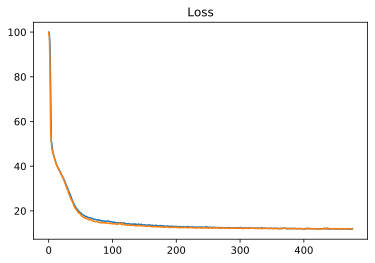

In [44]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [51]:
model.load_weights('best_model.hdf5')
model.save('nn_1.hdf5')

In [52]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 11.89%


In [53]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission['price'] = sample_submission['price'].apply(lambda x: round(x//1000)*1000)
sample_submission.to_csv('nn1_submission-v2.csv', index=False)

In [54]:
sample_submission.head()

,sell_id,price
0,1099427284,537000
1,1096405886,2340000
2,1100195294,647000
3,1099827282,496000
4,1100076198,2911000
